## Init

In [62]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Users\dawson\Documents\GitHub\new-peak-project\src


In [63]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [64]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [149]:
import os 

### parameters 

notebook_name = 'exp9_new_experiment' # name of the notebook

## Generation of ground truth model 

model_name = 'v4_drug_model' # name of the model
o_random_seed = 40
# p_overall_seed = 46 # different seed for parameter generation
no_observable_species = 2
no_feedback_regulations = 0
specie_value_range = (1000, 5000)
param_range = (0.05, 20)
param_multiplier_range = (0.5, 1.5)


## Simulation parameters 

simulation_time = 1000 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'lhs'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
- 'random parameter': randomizes a x% of parameter values of the model
'''

''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_40__50/


## Analysis

### Virtual Cell Creation

In [150]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
drug_0 = Drug('D0', 500, 500)
rng = np.random.default_rng(o_random_seed)
# add random 'up' and 'down' regulations to the drug
regulation_dir = []
for i, s in enumerate(model_drug_spec.A_species):
    reg_type = str(rng.choice(['up', 'down']))
    regulation_dir.append(reg_type)
    drug_0.add_regulation(s, reg_type)
model_drug_spec.add_drug(drug_0)
print(model_drug_spec)
print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1']
B Species: ['B0', 'B1']
C Species: ['C']
Regulations: [('A0', 'B0'), ('A1', 'B1'), ('B0', 'C'), ('B0', 'C'), ('D0', 'A0'), ('D0', 'A1')]
Regulation Types: ['up', 'up', 'up', 'down', 'down', 'down']
Drugs:
Drug(D0, 500, ['A0', 'A1'], ['down', 'down'])

Feedback: []


In [151]:
p_random_seeds = []
feature_size = 1000 
rng = np.random.default_rng(o_random_seed)
# generate `feature_size` random seeds for different parameter sets using numpy, ensure that the seeds are unique
p_random_seeds = rng.choice(range(1000000), feature_size, replace=False).tolist()

In [152]:
G0_d = model_drug_spec.generate_network('drug_model_524', 
                                        specie_value_range, 
                                        param_range, 
                                        param_multiplier_range,  
                                        verbose=0,
                                        random_seed=p_random_seeds[0])
base_parameters = G0_d.get_parameters()
base_initial_conditions = G0_d.get_state_variables()

print(G0_d.get_antimony_model())

model drug_model_524

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km*(1+D0*J1_Kic0) + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km*(1+D0*J3_Kic0) + A1)
J4: B0p -> B0; J4_Vmax*B0p/(J4_Km + B0p)
J5: B0 -> B0p; (J5_Vmax+A0p*J5_Kw0)*B0/(J5_Km + B0)
J6: B1p -> B1; J6_Vmax*B1p/(J6_Km + B1p)
J7: B1 -> B1p; (J7_Vmax+A1p*J7_Kw0)*B1/(J7_Km + B1)
J8: C -> Cp; (J8_Vmax+B0p*J8_Kw0)*C/(J8_Km*(1+B0p*J8_Kic0) + C)
J9: Cp -> C; J9_Vmax*Cp/(J9_Km + Cp)

# State variables in the system
A0p=0
A0=1061
A1p=0
A1=4729
B0p=0
B0=2122
B1p=0
B1=2335
C=100
Cp=0

# Parameters in the system
J0_Km=1555.540384771491
J0_Vmax=78.88729860879982
J1_Km=1555.540384771491
J1_Vmax=7.888729860879983
J1_Kic0=0.17285122025732524
J2_Km=1555.540384771491
J2_Vmax=78.88729860879982
J3_Km=1555.540384771491
J3_Vmax=7.888729860879983
J3_Kic0=0.17285122025732524
J4_Km=1555.540384771491
J4_Vmax=78.88729860879982
J5_Km=1555.540384771491
J5_Vmax=7.888729860879983
J5_Kw0=0.17285122

In [153]:
parameter_sets = []
for p in p_random_seeds: 
    model_build = model_drug_spec.generate_network(f'param_seed_{p}', 
                                            specie_value_range, param_range, param_multiplier_range, random_seed=p, verbose=0)
    parameter_sets.append(model_build.get_parameters())

In [154]:
# test simulation 

from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(G0_d.get_sbml_model())

result = solver.simulate(0, 1000, 100)
result

,time,A0p,A0,A1p,A1,B0p,B0,B1p,B1,C,Cp
0,0.00000,0.000000,1061.000000,0.000000,4729.000000,0.000000,2122.000000,0.000000,2335.000000,100.000000,0.000000
1,10.10101,25.143016,1035.856984,47.088401,4681.911599,47.536013,2074.463987,59.919366,2275.080634,99.739650,0.260350
2,20.20202,40.156697,1020.843303,76.001612,4652.998388,91.584881,2030.415119,126.513275,2208.486725,99.749373,0.250627
3,30.30303,49.207781,1011.792219,94.073643,4634.926357,128.058089,1993.941911,187.084191,2147.915809,99.768857,0.231143
4,40.40404,54.694904,1006.305096,105.489540,4623.510460,156.623746,1965.376254,237.937373,2097.062627,99.785768,0.214232
...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,1.203784,1059.796216,5.239386,4723.760614,95.883906,2026.116094,109.242601,2225.757399,99.788822,0.211178
96,969.69697,1.203783,1059.796217,5.239386,4723.760614,95.883901,2026.116099,109.242588,2225.757412,99.788822,0.211178
97,979.79798,1.203783,1059.796217,5.239386,4723.760614,95.883895,2026.116105,109.242574,2225.757426,99.788822,0.211178
98,989.89899,1.203783,1059.796217,5.239385,4723.760615,95.883890,2026.116110,109.242561,2225.757439,99.788822,0.211178


### Generate synthetic 'omics-like' data

In [162]:
from models.SyntheticGen import generate_feature_data, generate_target_data, generate_feature_data_v2, generate_target_data_diff_build

feature_data = generate_feature_data_v2(model_drug_spec, base_initial_conditions, feature_generation_method, feature_generation_extra_params, 1000, feature_generation_seed)
target_data, _ = generate_target_data_diff_build(model_drug_spec, solver, 
                                                 feature_data, parameter_sets, 
                                                 {'start': 0, 'end': 1000, 'points': 100}, 
                                                 n_cores=1, verbose=True)


Simulating perturbations:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating perturbations: 100%|██████████| 1000/1000 [00:04<00:00, 243.65it/s]


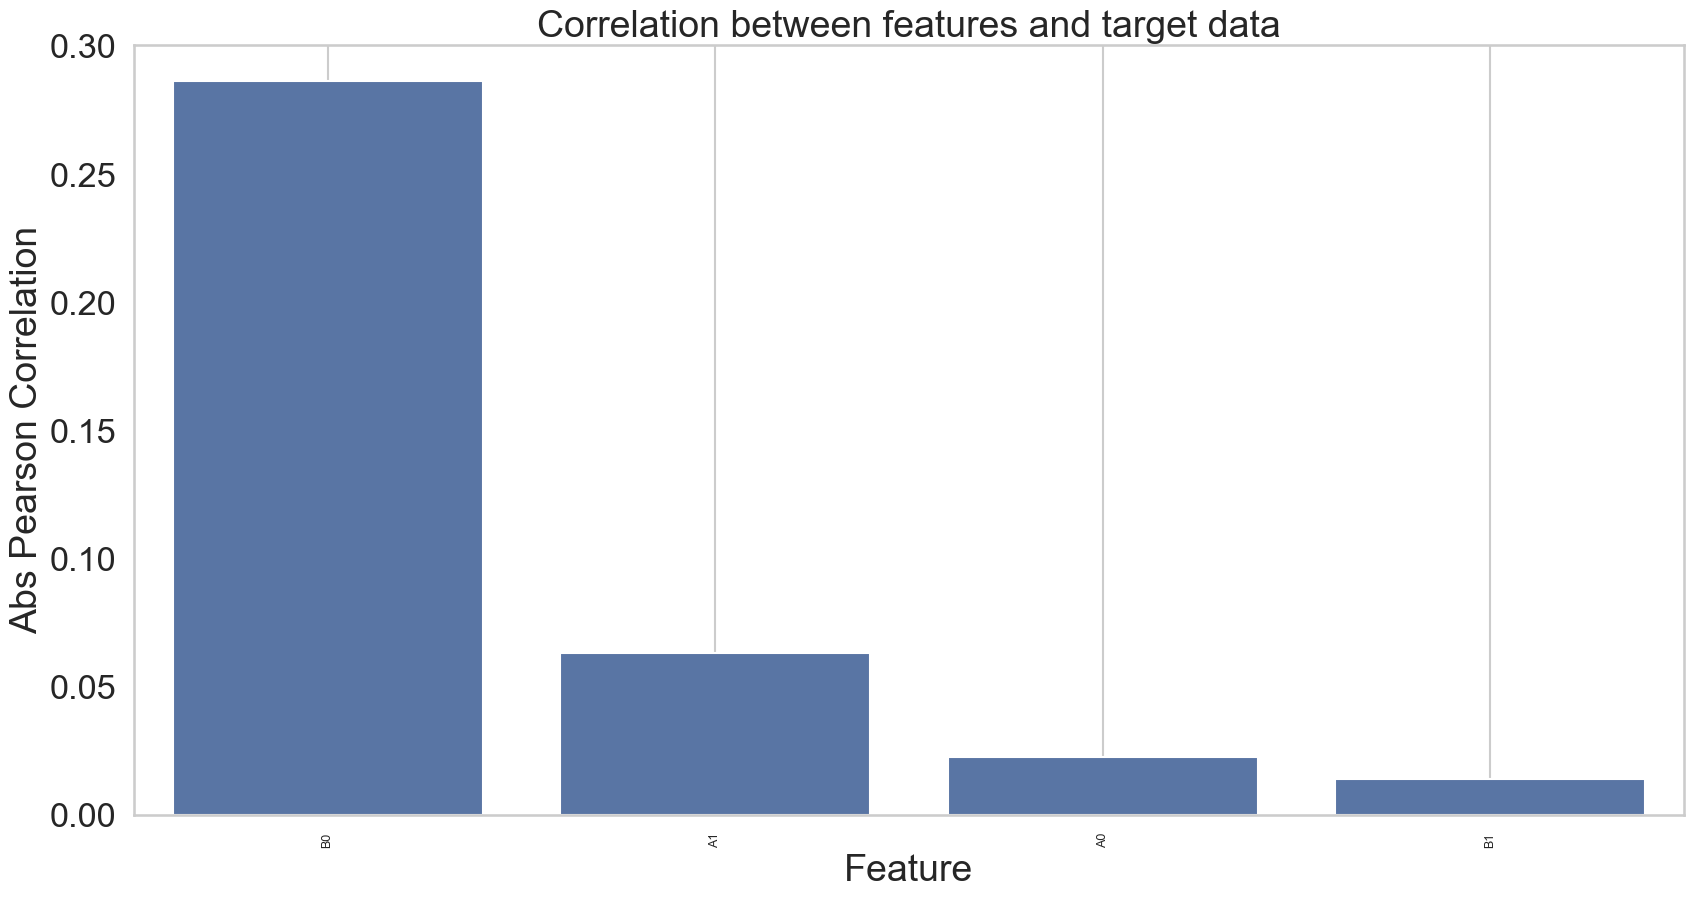

In [163]:
# plot the association between the features and the target data in a bar chart based on the correlation values 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# create a dataframe with the feature data and target data
feature_data_df = pd.DataFrame(feature_data)
target_data_df = pd.DataFrame(target_data)
# add the target data to the feature data
feature_data_df['target'] = target_data_df['Cp']

# calculate the correlation between the features and the target data
correlation = feature_data_df.corr()['target'].sort_values(ascending=False)
# create a dataframe with the correlation values
correlation_df = pd.DataFrame(correlation)
correlation_df = correlation_df.reset_index()
correlation_df.columns = ['feature', 'correlation']
# do not include the target data in the correlation dataframe
correlation_df = correlation_df[correlation_df['feature'] != 'target']
abs_correlation_df = correlation_df.copy()
# take the absolute value of the correlation
abs_correlation_df['correlation'] = abs(abs_correlation_df['correlation'])
# sort the dataframe by the absolute value of the correlation
abs_correlation_df = abs_correlation_df.sort_values(by='correlation', ascending=False)
abs_correlation_df_50 = abs_correlation_df.head(50)
# plot the correlation values
plt.figure(figsize=(20, 10))
sns.barplot(x='feature', y='correlation', data=abs_correlation_df_50)
plt.title('Correlation between features and target data')
plt.xlabel('Feature')
plt.ylabel('Abs Pearson Correlation')
plt.xticks(rotation=90, fontsize=9)
plt.grid()
plt.show()

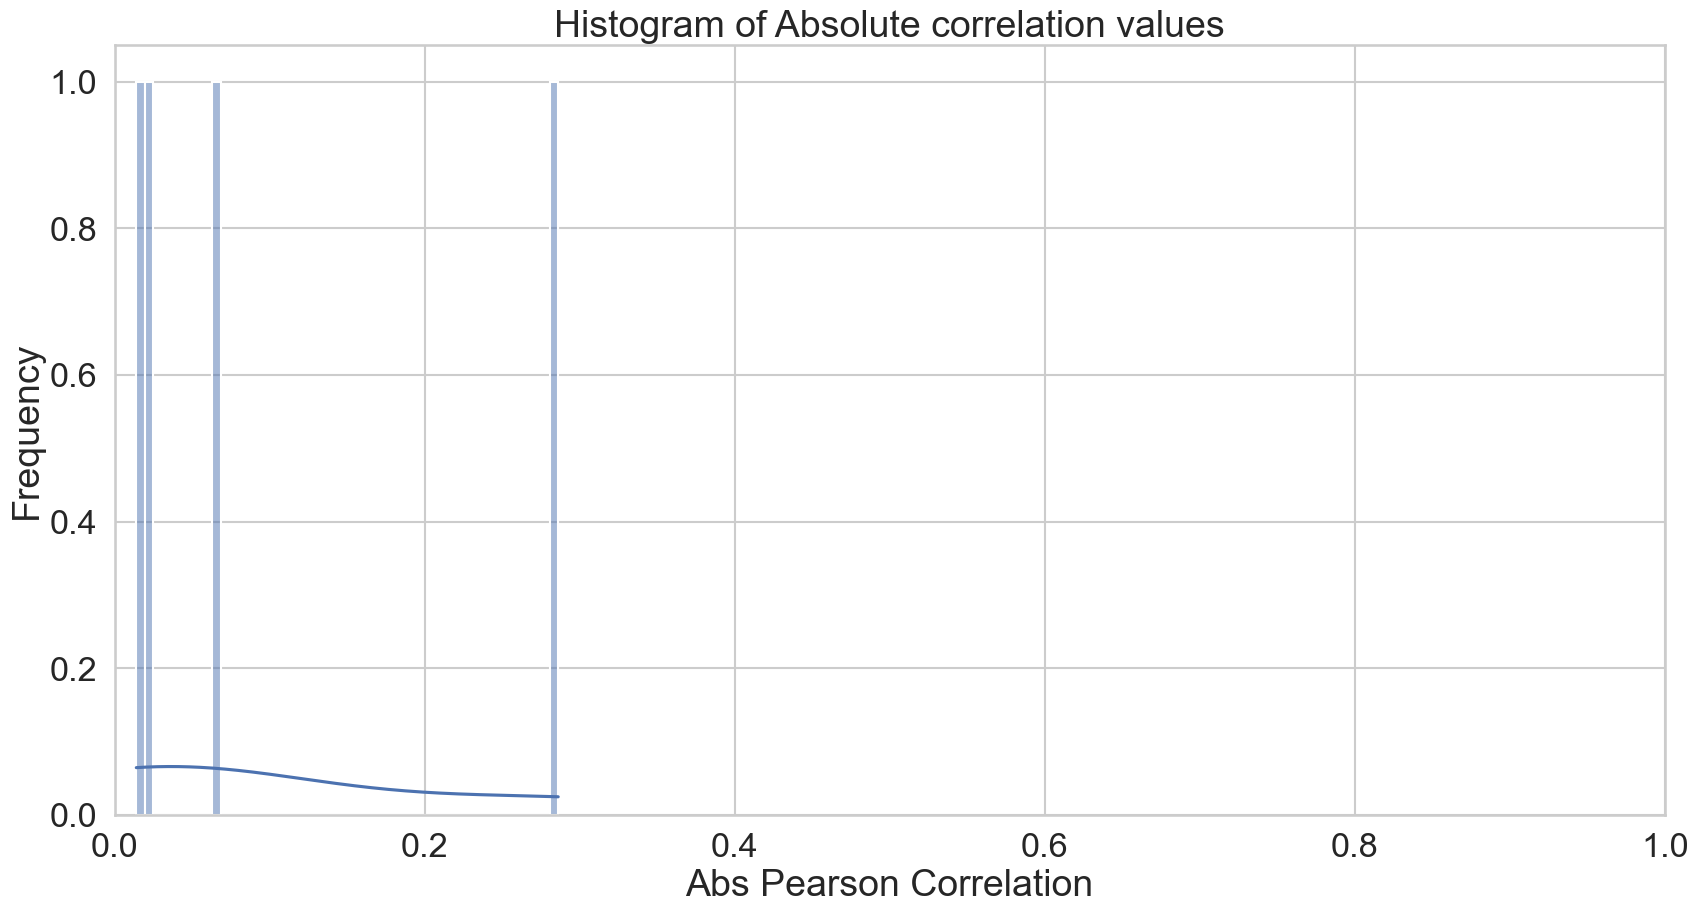

In [164]:
# make a histogram of the correlation values
plt.figure(figsize=(20, 10))
sns.histplot(abs_correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of Absolute correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(0,1)
plt.show()

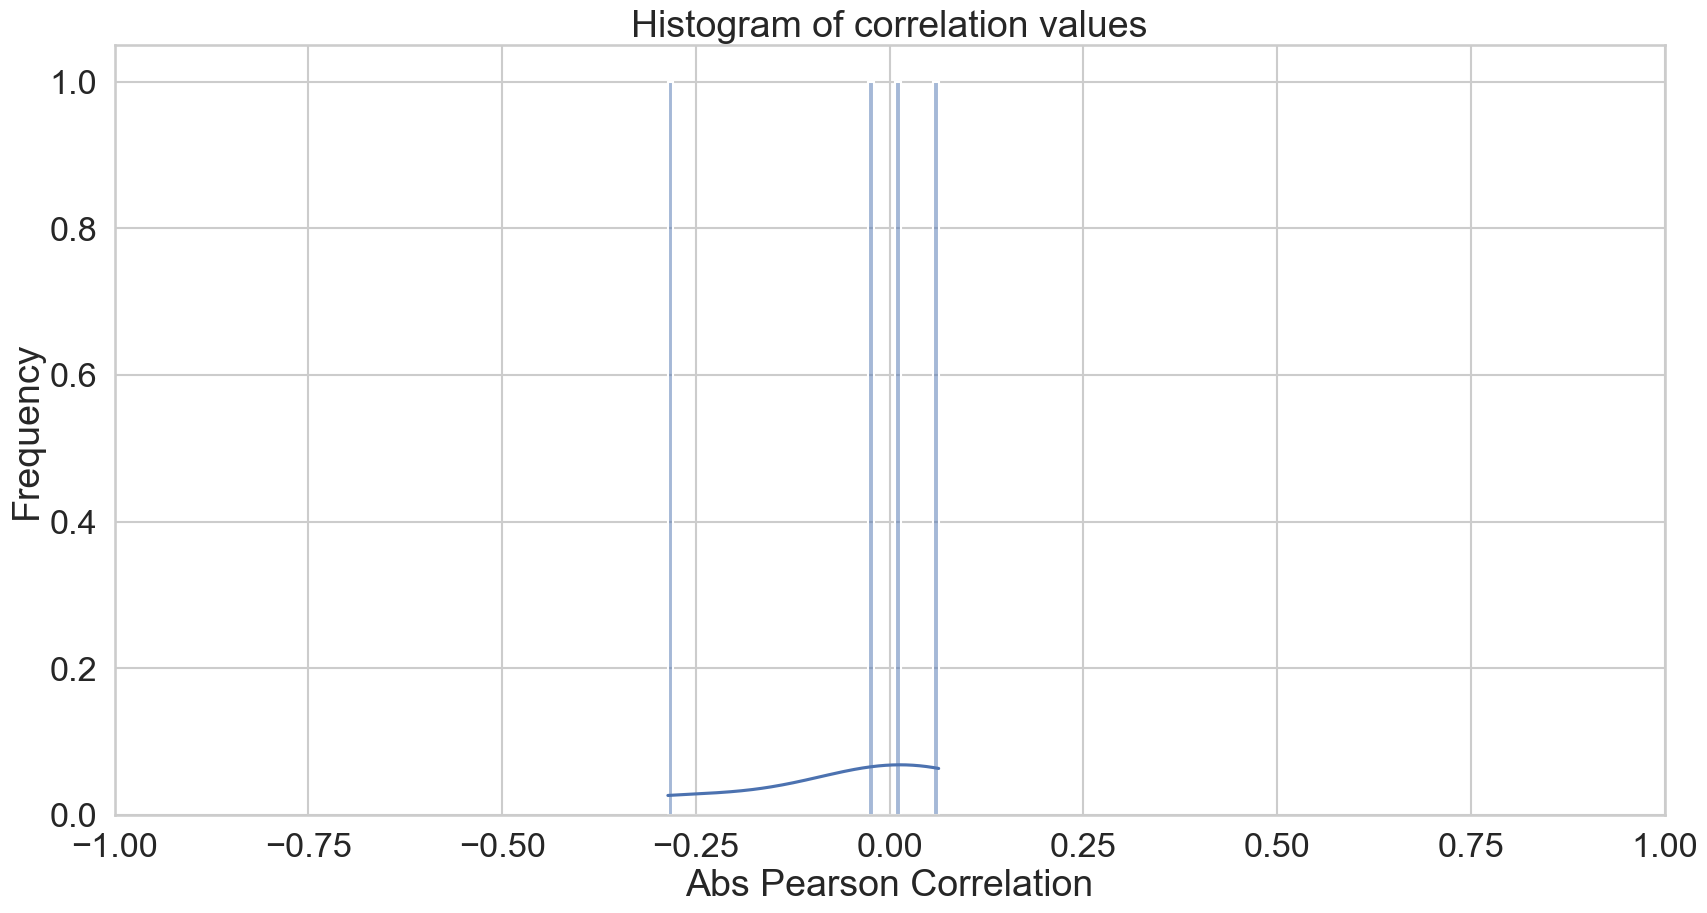

In [165]:
# make a histogram of the correlation values
plt.figure(figsize=(20, 10))
sns.histplot(correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(-1,1)
plt.show()

In [166]:
# extract the mean and standard deviation of the correlation values
mean = np.mean(correlation_df['correlation'])
std = np.std(correlation_df['correlation'])
max_val = np.max(correlation_df['correlation'])
min_val = np.min(correlation_df['correlation'])
outliers = correlation_df[(correlation_df['correlation'] > mean + 3*std) | (correlation_df['correlation'] < mean - 3*std)]

print(f'Mean: {mean:.4f}')
print(f'Standard Deviation: {std:.4f}')
print(f'Max: {max_val:.4f}')
print(f'Min: {min_val:.4f}')
print(f'Outliers as a ratio of all features: {outliers.shape[0] / correlation_df.shape[0]:.4f}')

Mean: -0.0579
Standard Deviation: 0.1353
Max: 0.0632
Min: -0.2861
Outliers as a ratio of all features: 0.0000


4 features selected based on correlation with target data


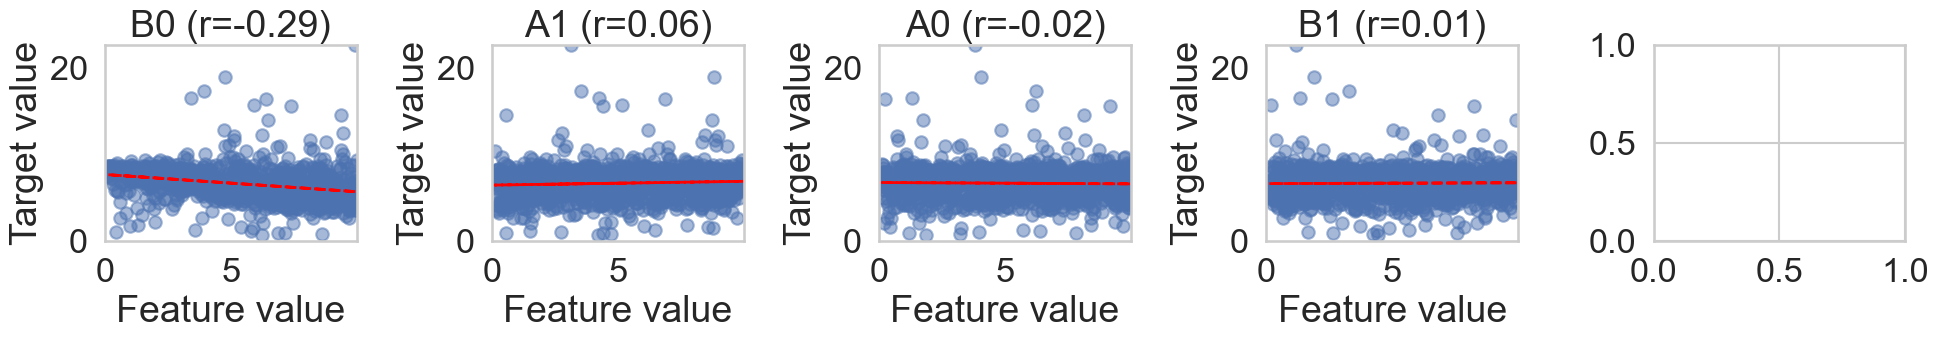

In [167]:
# plot association between the features and the target data 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for each feature, plot the association with the target data, which is only a series 
# plot all features in separate subplots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.5) 

n_features = len(feature_data.columns)
# plot only the top 10 features based on the absolute correlation values
top_features = abs_correlation_df['feature'].values[:10]
# create a new dataframe with only the top features
top_feature_data = feature_data[top_features]
print(f'{len(top_feature_data.columns)} features selected based on correlation with target data')
# make a subplot based on the size of feature_data, have five columns and as many rows as needed
top_n_features = len(top_feature_data.columns)
n_rows = int(top_n_features / 5) if top_n_features % 5 == 0 else int(top_n_features / 5) + 1
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axs = axs.flatten()


# plot each feature in a separate subplot
for i, feature in enumerate(top_feature_data.columns):
    x = top_feature_data[feature].values.ravel()  # ensure 1D
    y = target_data.values.ravel()            # ensure 1D
    axs[i].scatter(x, y, alpha=0.5)
    # add a dash linear regression line with a pearson correlation coefficient
    # compute the pearson correlation coefficient
    corr, _ = pearsonr(x, y)
    # add a linear regression line
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    axs[i].plot(x, y_pred, color='red', linestyle='--', linewidth=2)
    axs[i].set_title(f'{feature} (r={corr:.2f})')

    axs[i].set_xlabel('Feature value')
    axs[i].set_ylabel('Target value')
    axs[i].grid()
    # set the x and y limits to be the same for all subplots
    max_feature = top_feature_data[feature].values.max()   
    max_target = target_data.values.max()  
    axs[i].set_xlim([0,max_feature])
    axs[i].set_ylim([0,max_target])
    # compute the correlation between the feature and target data
plt.tight_layout()
plt.show()

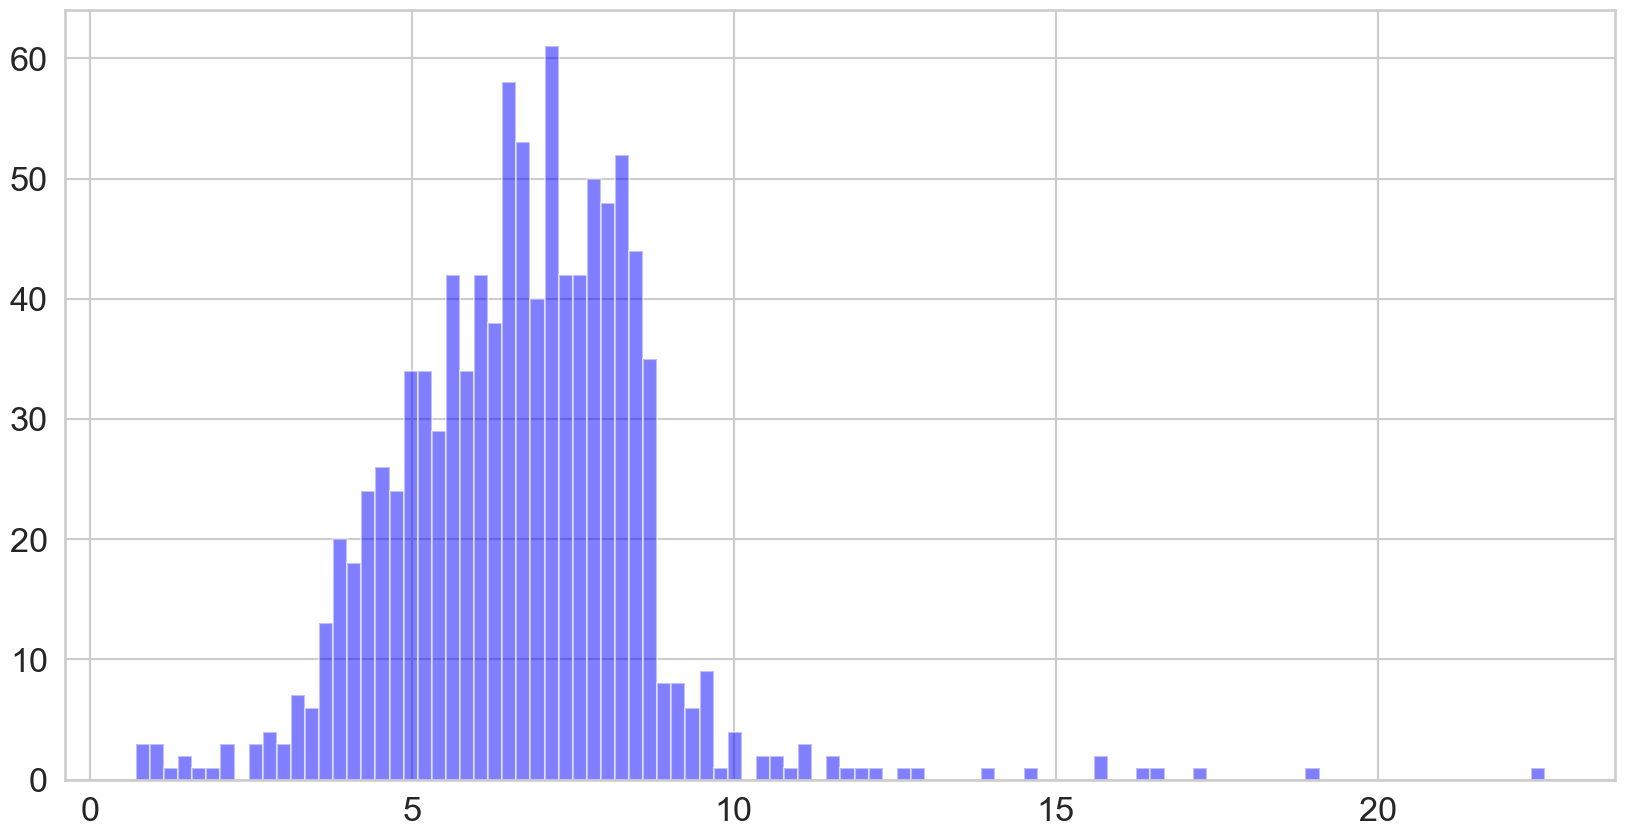

In [168]:
# plot the target data only with the x axis being 0 to 100 
plt.figure(figsize=(20, 10))
plt.hist(target_data, bins=100, alpha=0.5, color='blue')
plt.show()

### Suboptimal Model Creation

#### If modifying at the model architectural level

Mostly done to modify the `ModelSpec` object, where the updated spec information is transferred to a new `ModelBuilder` object, which then need to transpile to Antimony/SBML for a Solver instance. 

NewSpec --> NewBuilder --> Update parameters to original builder --> Transpile to Antimony/SBML --> Solver instance

#### If only changes to states and parameters are needed

Simply duplicate the `ModelBuilder` object and update the states and parameters.
```


In [169]:
# randomise links and parameters by using a different random seed

new_spec = DrugModelSpecification()
new_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
new_spec.add_drug(drug_0)
print(new_spec)
print(f'Feedback: {new_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1']
B Species: ['B0', 'B1']
C Species: ['C']
Regulations: [('A0', 'B0'), ('A1', 'B1'), ('B0', 'C'), ('B0', 'C'), ('D0', 'A0'), ('D0', 'A1')]
Regulation Types: ['up', 'up', 'up', 'down', 'down', 'down']
Drugs:
Drug(D0, 500, ['A0', 'A1'], ['down', 'down'])

Feedback: []


In [170]:
new_model = new_spec.generate_network('drug_model_552', specie_value_range, param_range, param_multiplier_range, random_seed=100005352, verbose=0)
new_base_parameters = new_model.get_parameters()
new_base_initial_conditions = new_model.get_state_variables()

In [171]:
new_solver = RoadrunnerSolver()
new_solver.compile(new_model.get_sbml_model())
new_result = new_solver.simulate(0, 1000, 100)

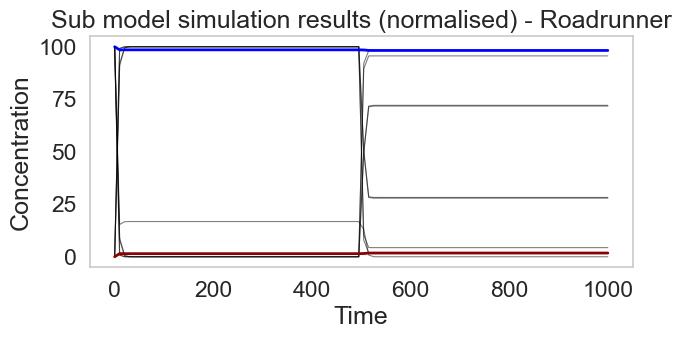

In [172]:
# use pandas default plot to plot the simulation results
import matplotlib.pyplot as plt
import seaborn as sns

states_variable_names = G0_d.get_state_variables()
result = new_result

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(7, 3))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Sub model simulation results (normalised) - Roadrunner')
plt.grid()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### Simulation / Extract dynamic feature data

In [173]:
# Minor distortion of the parameters to create a new set of parameters

rng = np.random.default_rng(o_random_seed)
modified_parameter_sets = []
for params in parameter_sets:
    new_params = {}
    for key, value in params.items(): 
        new_params[key] = value * rng.uniform(0.1, 10) # distortion range, expectation is that the larger the worse the model performance 
    modified_parameter_sets.append(new_params)

In [174]:
from models.SyntheticGen import generate_model_timecourse_data, generate_model_timecourse_data_diff_build

new_base_parameters_set = []
for p in p_random_seeds: 
    new_base_parameters_set.append(new_base_parameters)

# generate the timecourse data for the new model
time_course_data = generate_model_timecourse_data_diff_build(new_spec, 
                                                  new_solver, 
                                                  feature_data, 
                                                  modified_parameter_sets,
                                                  {'start': 0, 'end': 1000, 'points': 100}, 
                                                  capture_species='all', n_cores=1, verbose=True)


Simulating perturbations: 100%|██████████| 1000/1000 [00:04<00:00, 225.90it/s]


In [175]:
from models.Utils import last_time_point_method, dynamic_features_method

all_species = model_drug_spec.A_species + model_drug_spec.B_species + model_drug_spec.C_species
all_phos_species = [s+'p' for s in all_species]
# apply the data engineering method to the feature data
last_time_data = last_time_point_method(time_course_data, all_phos_species)

In [176]:
dynamic_data = dynamic_features_method(time_course_data, all_phos_species, n_cores=8)

In [177]:
combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)


In [178]:
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

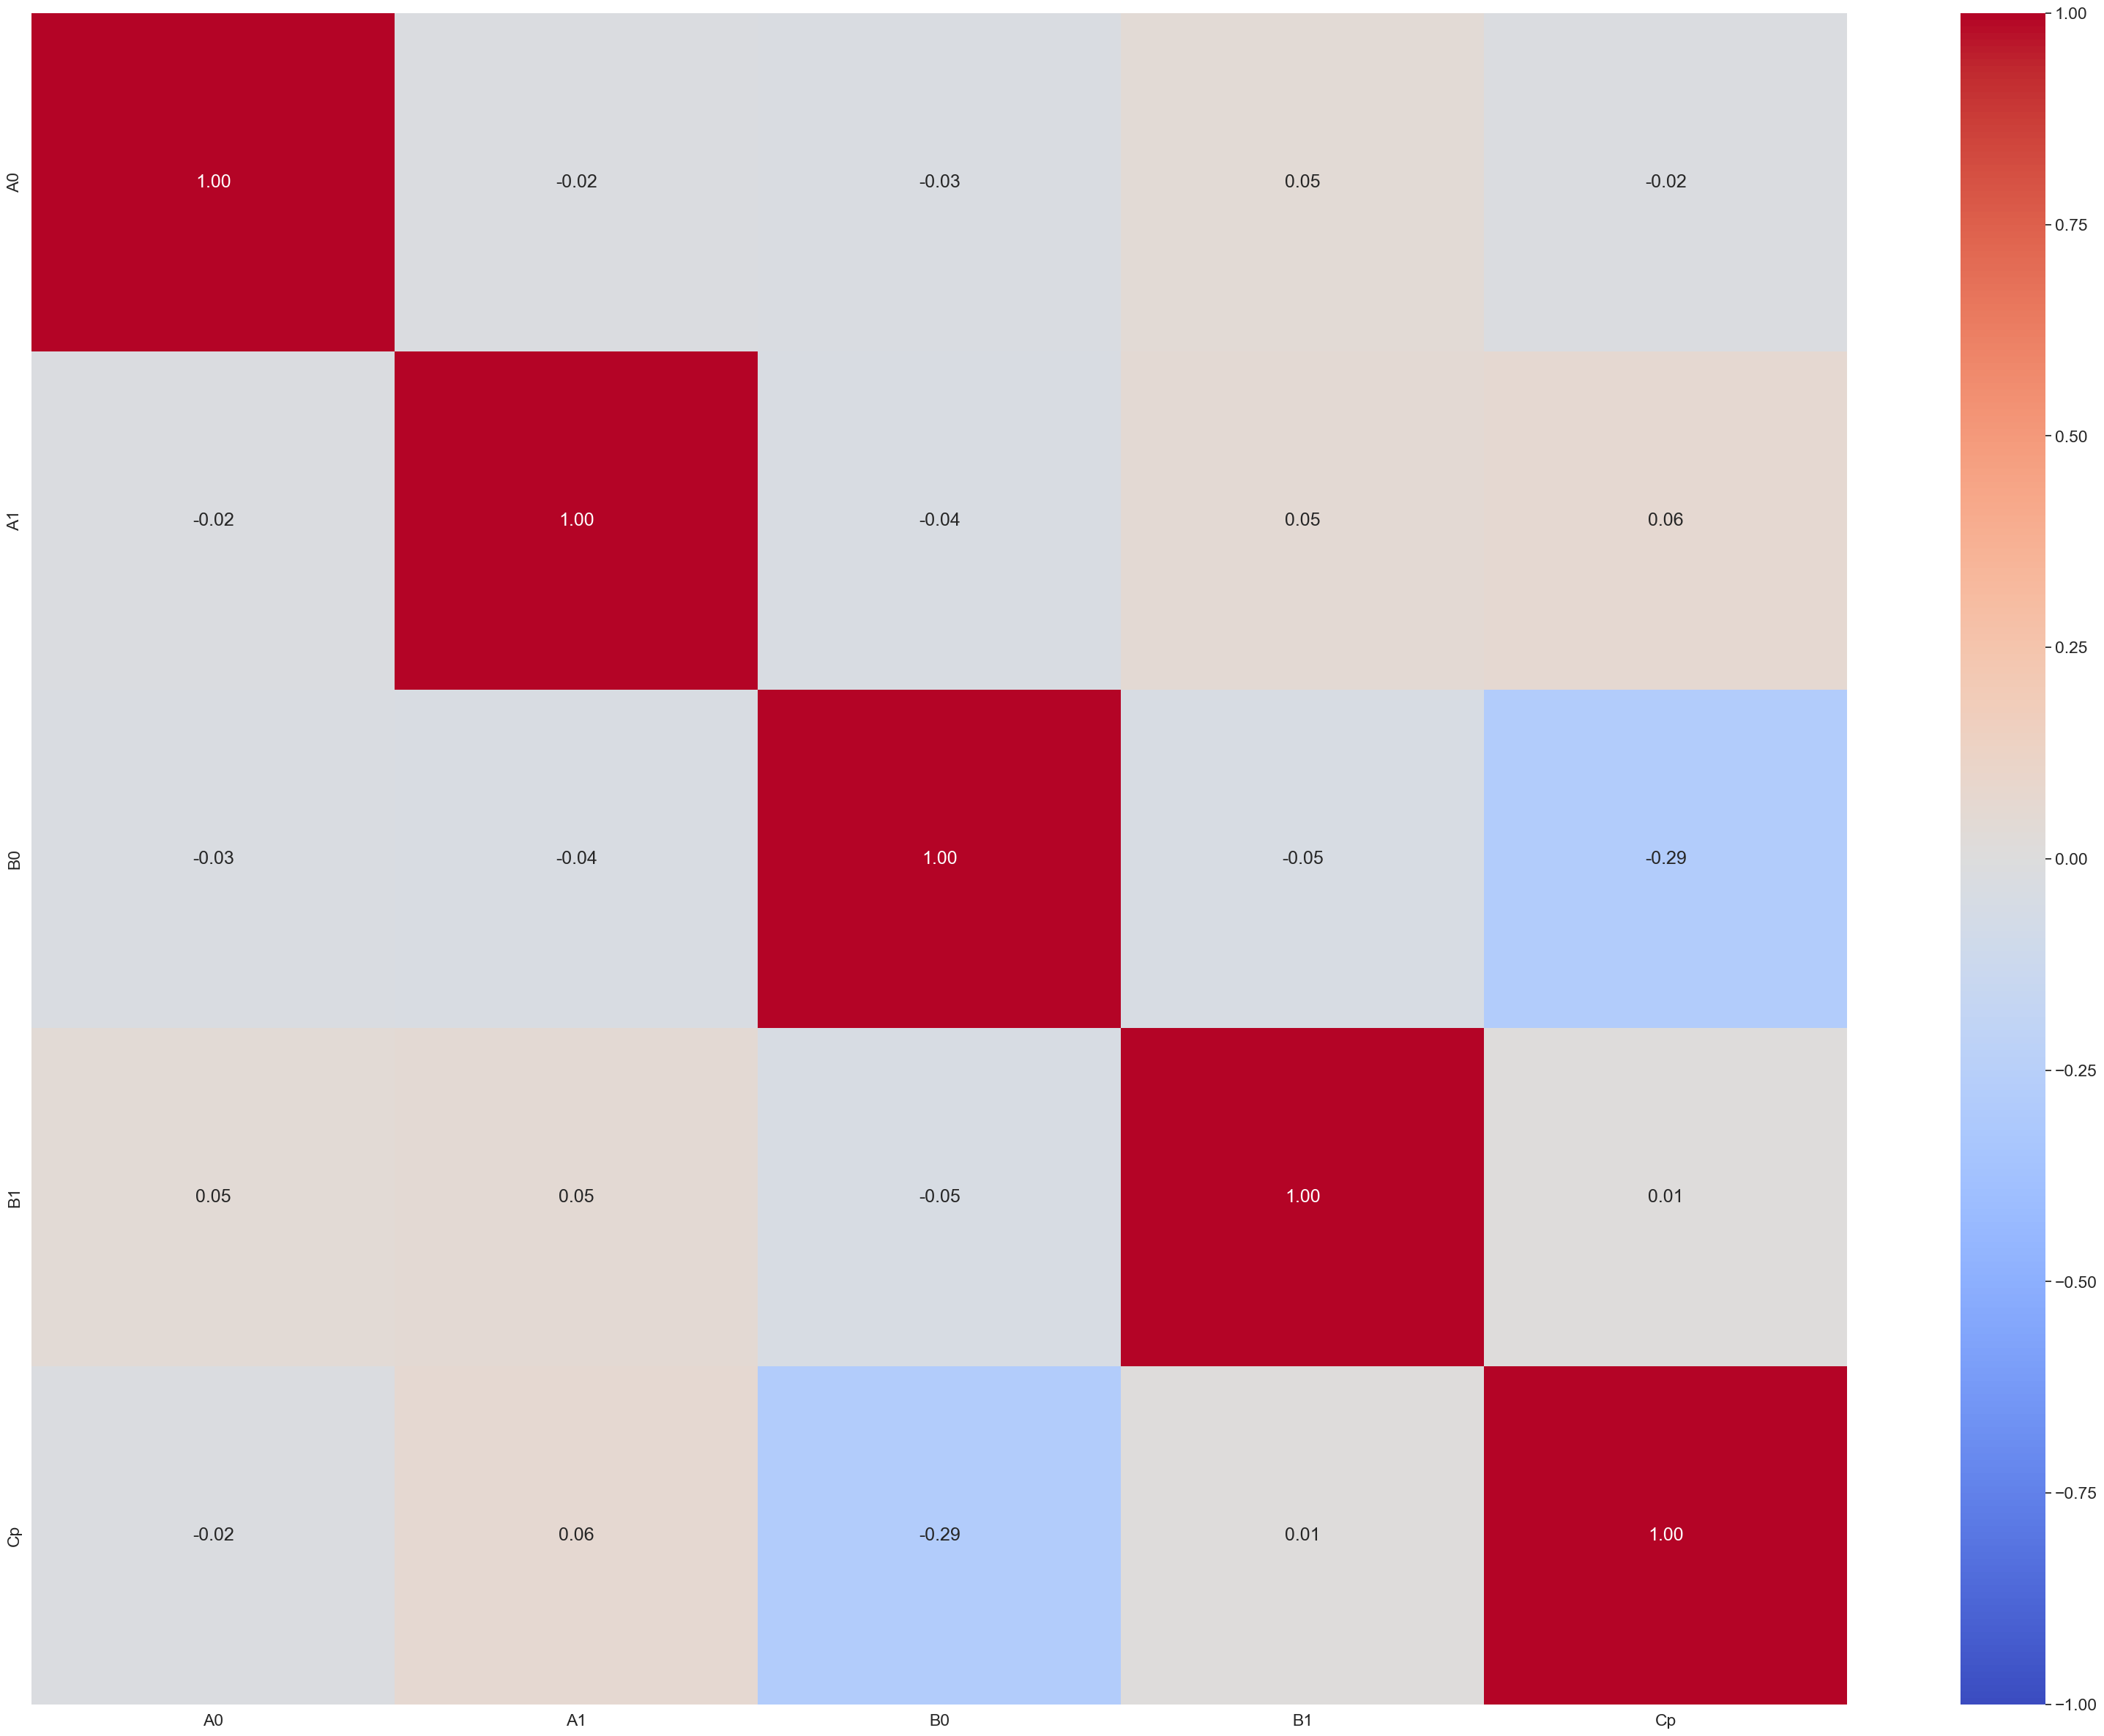

In [179]:
import seaborn as sns
feature_target_df = feature_data.copy()
feature_target_df['Cp'] = target_data['Cp']
plt.figure(figsize=(40, 30))
sns.heatmap(feature_target_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.show()

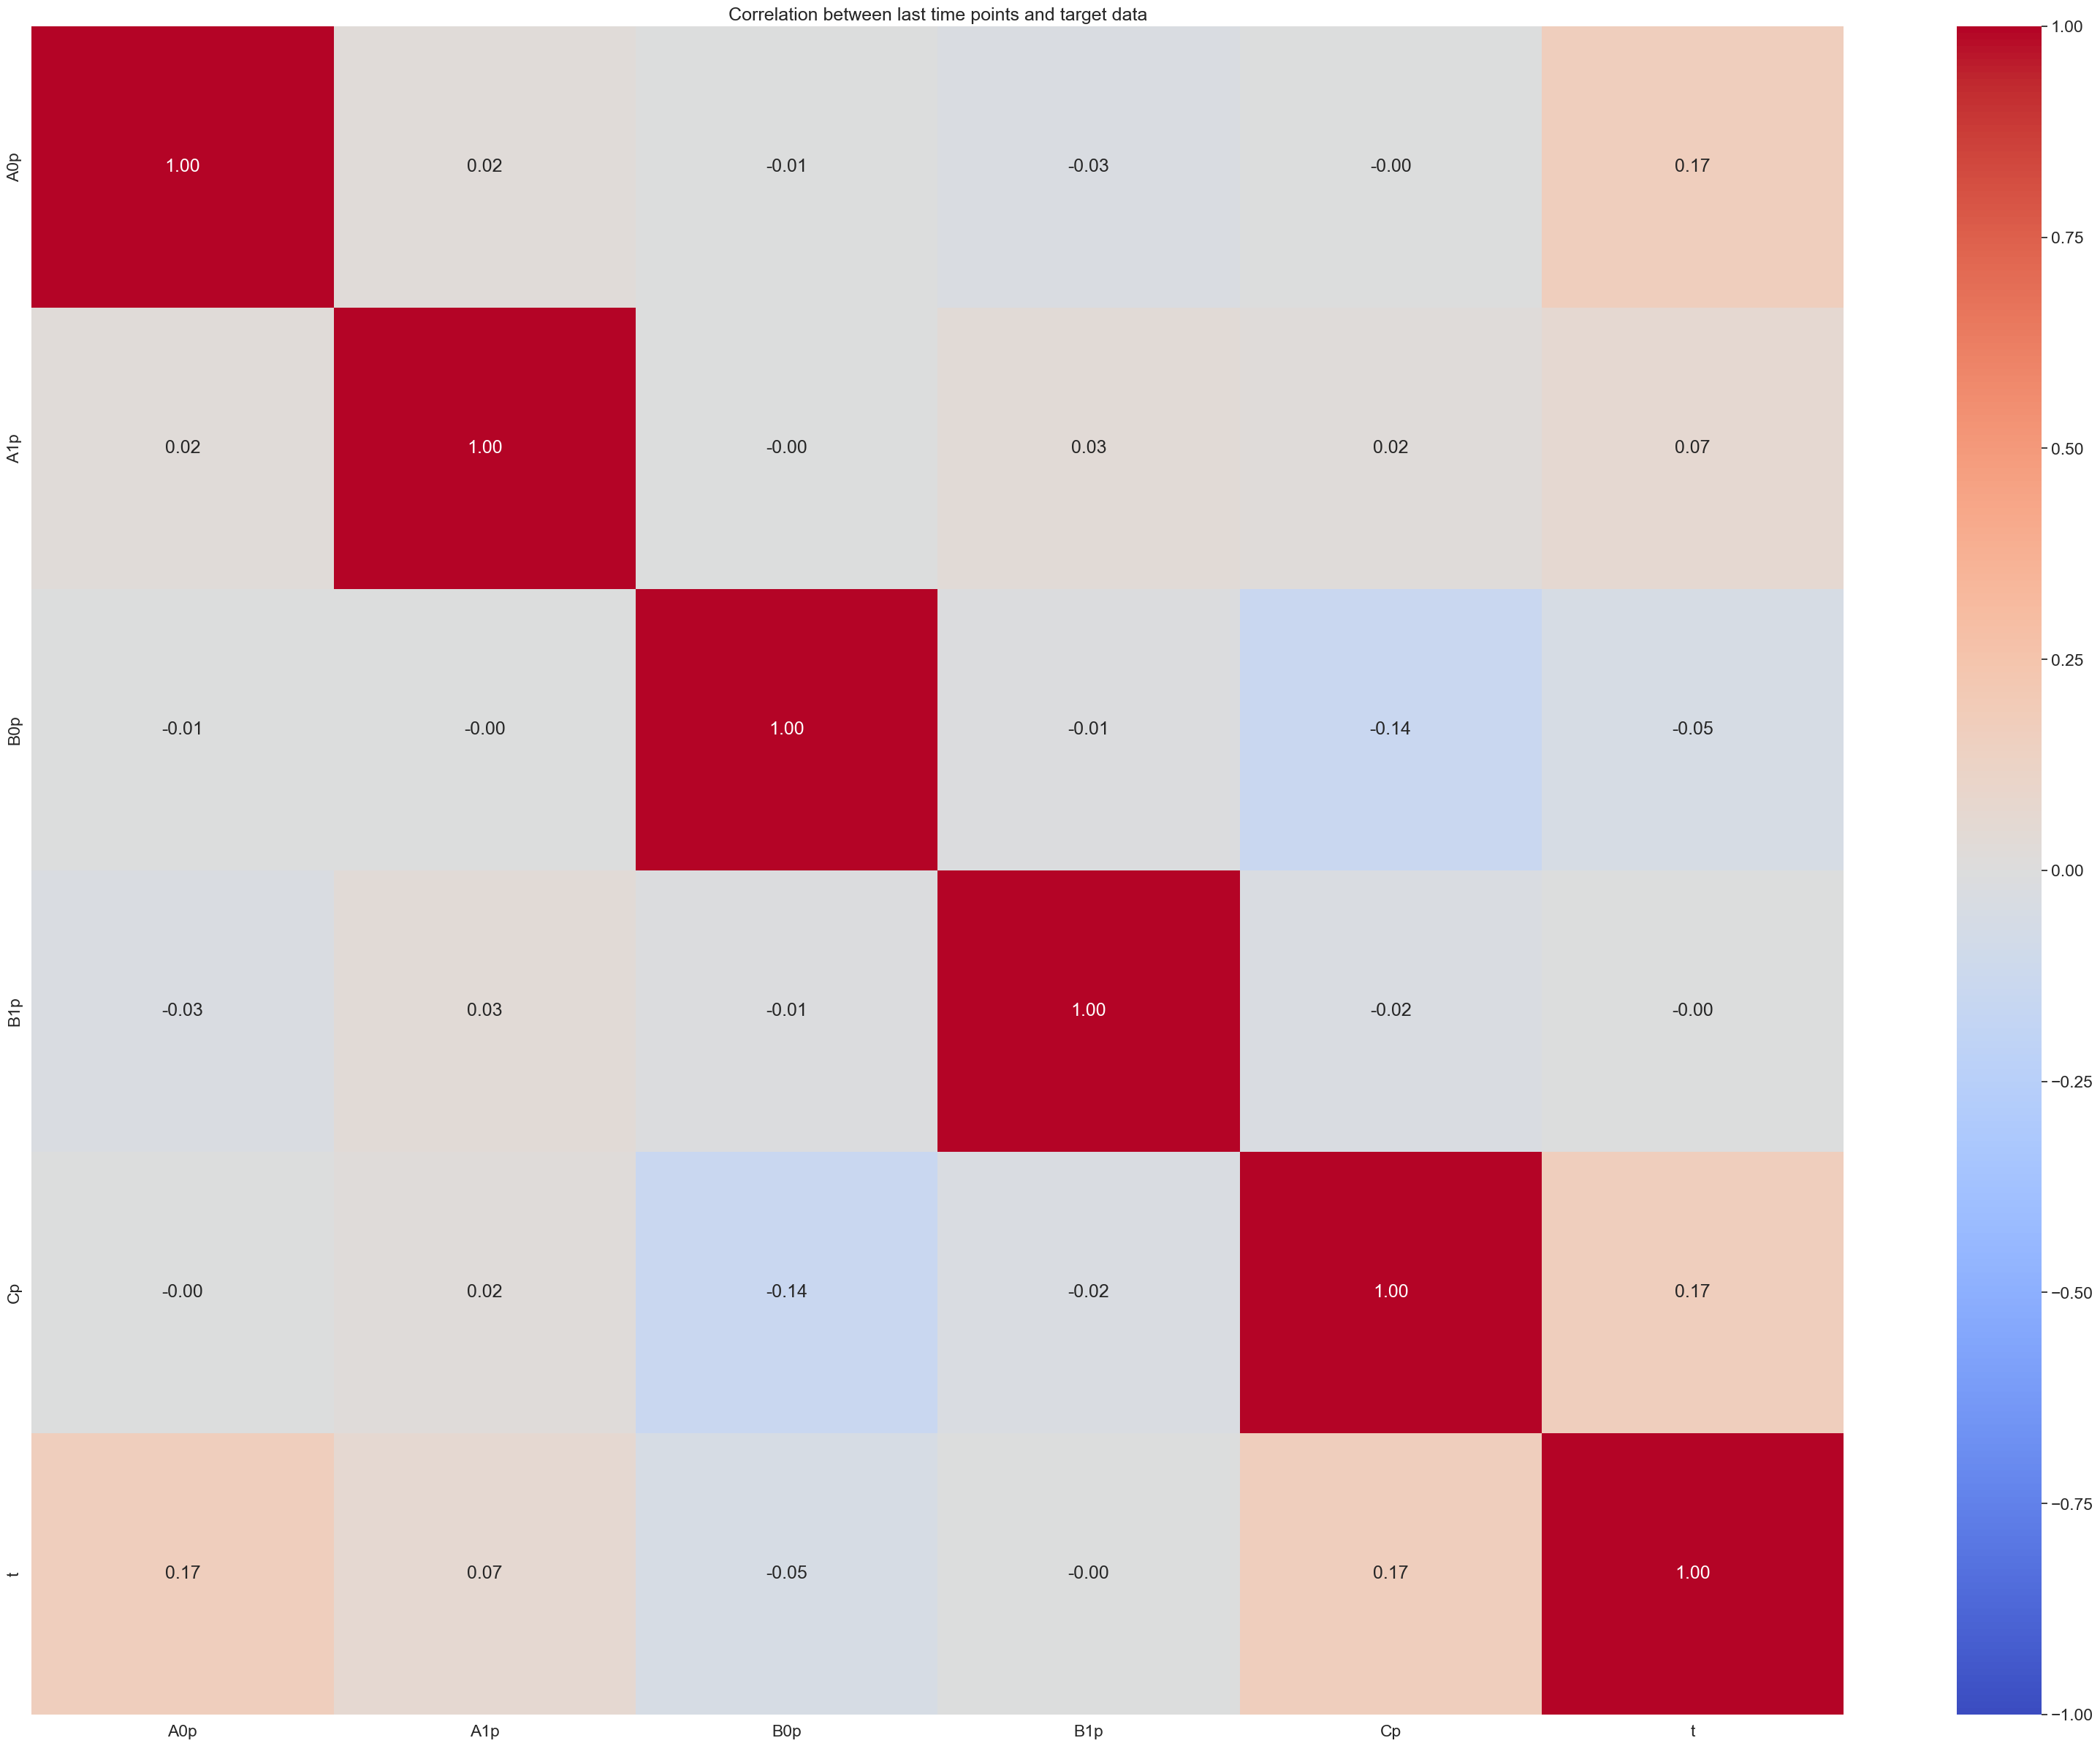

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt
# perform correlation analysis between the last time points and the target data
target_last_time_points_S0 = last_time_data.copy()
target_last_time_points_S0['t'] = target_data['Cp']
plt.figure(figsize=(40, 30))
# ensure color map is consistent with the previous heatmap
sns.heatmap(target_last_time_points_S0.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation between last time points and target data')
plt.show()

### Machine Learning Training

In [181]:
def evaluate_model(model, model_name, feature_data, feature_data_name, target_data, test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = feature_data_list
all_features_desc = feature_data_names
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

parallelise = True 
from tqdm import tqdm
# tqdm is a progress bar library, use it to show the progress of the model evaluation
metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value
0,Linear Regression,feature_data,4.441463,0.020059,0.182953,9.513014e-03
1,Linear Regression,feature_data,2.536276,0.130733,0.365099,1.063342e-07
2,Linear Regression,feature_data,3.385784,0.133299,0.383219,2.132825e-08
3,Linear Regression,feature_data,2.931638,0.055209,0.285843,4.077880e-05
4,Linear Regression,feature_data,4.471637,0.031135,0.210866,2.724861e-03
...,...,...,...,...,...,...
245,Neural Network,combined_dyn_data,3.845290,-0.307066,0.434131,1.341909e-10
246,Neural Network,combined_dyn_data,4.074432,-0.006684,0.427148,2.830508e-10
247,Neural Network,combined_dyn_data,5.000206,-0.172508,0.376543,3.899332e-08
248,Neural Network,combined_dyn_data,4.985647,-0.857783,0.277125,7.107337e-05


In [182]:
if save_figures: 
    metric_df.to_pickle(experiment_folder+'metric_df.pkl')
    print('Metric data saved to:', experiment_folder+'metric_df.pkl')   


Metric data saved to: C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_40__50/metric_df.pkl


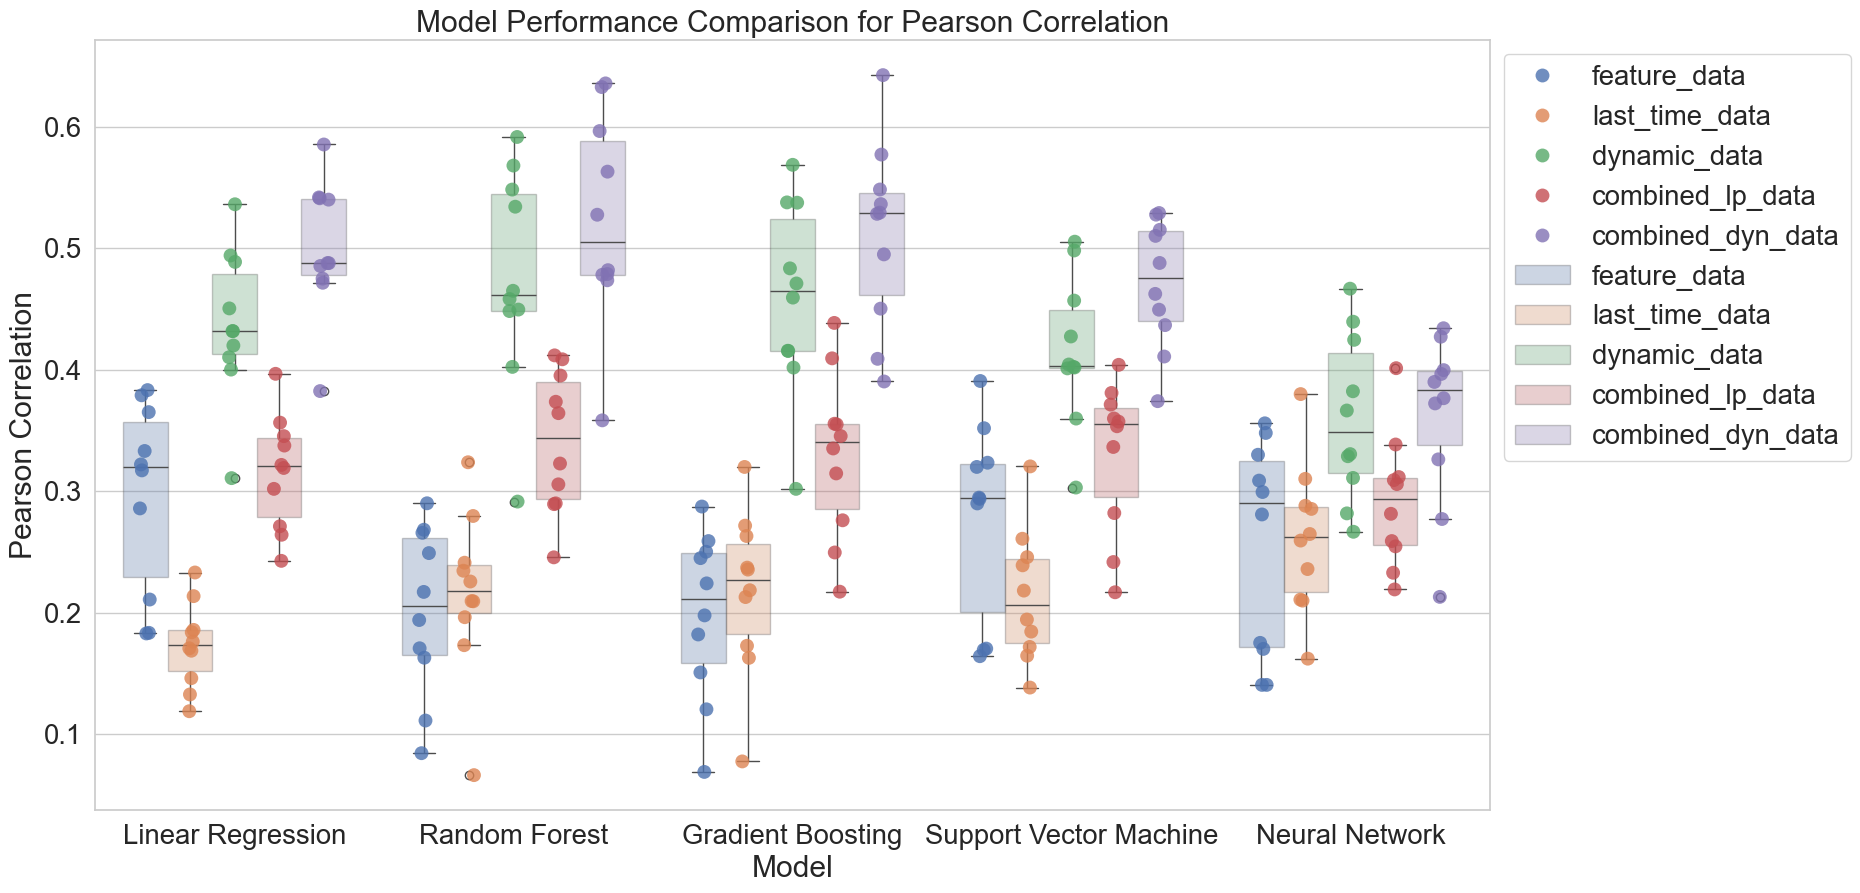

In [183]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# display the mean value for each model and feature data type
mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_13_model_performance_comparison_pearson.png')
plt.show()

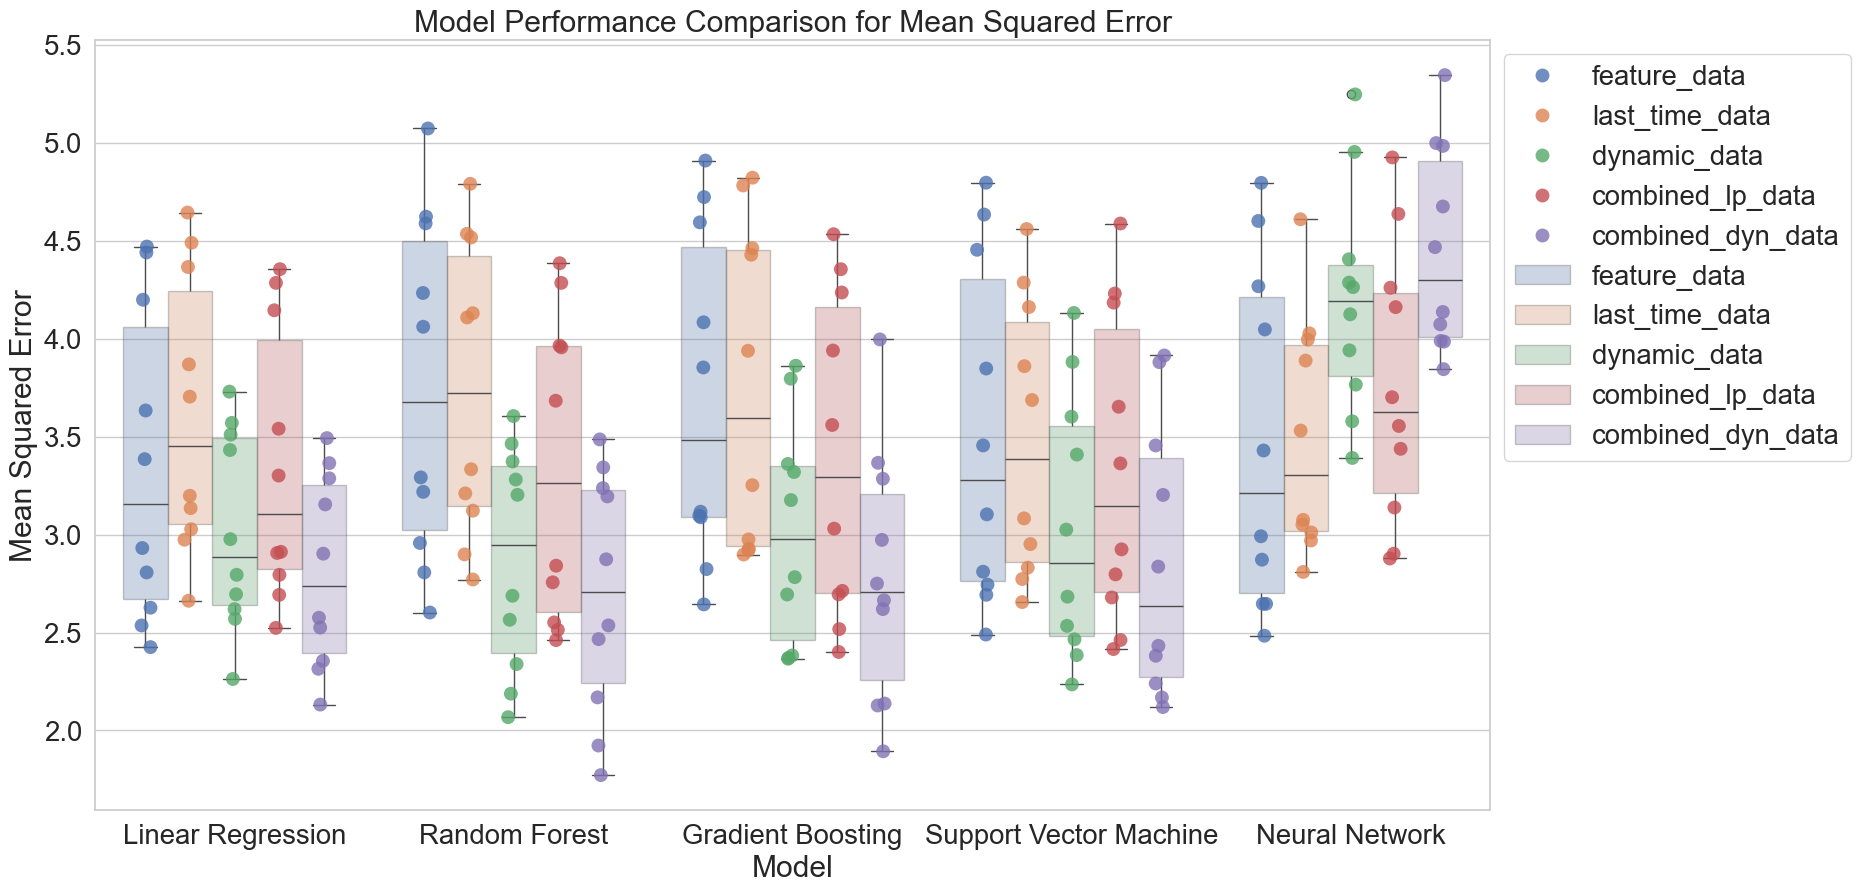

In [184]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Mean Squared Error')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_14A_all_model_performance_comparison_mse.png')
plt.show()